<a href="https://colab.research.google.com/github/Michaelzats/Assets-optimisation-predictor/blob/main/Assets_optimisation_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -q yfinance
# !pip install pandas-datareader
# !pip install pulp
# !pip install --upgrade pandas
# !pip install PyPortfolioOpt
# !pip install --upgrade pandas-datareader



     |████████████████████████████████| 109 kB 6.8 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
from pandas_datareader import data
from pulp import *
import requests
from pandas_datareader import data as pdr
import yfinance as yfin
from pypfopt.expected_returns import mean_historical_return
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models 
from pypfopt import expected_returns
from pypfopt.cla import CLA
import pypfopt.plotting as pplt
from matplotlib.ticker import FuncFormatter
import os


In [62]:
assets = ['ENJ-USD','DOGE-USD', 'XLM-USD','LTC-USD','LINK-USD','CHZ-USD','ETH-USD','SKL-USD', 'FIL-USD','ANKR-USD','ADA-USD','XRP-USD','ATOM-USD']



<bound method NDFrame.head of     Unnamed: 0
0            A
1          AAL
2          AAP
3         AAPL
4         ABBV
..         ...
499        YUM
500        ZBH
501       ZBRA
502       ZION
503        ZTS

[504 rows x 1 columns]>

In [63]:
initial_date = "2016-04-20"
today = datetime.today().strftime('%Y-%m-%d')


In [64]:
df_prices = pd.DataFrame()


In [65]:
# We give the function the empty dataframe, the name of the assets, the initial date and the end date:


def datosYahoo(dataframe,asset_list,start,finish):
    for i in asset_list:
        dataframe[i] = pdr.get_data_yahoo(i, start= initial_date , end=finish)["Adj Close"]
    return dataframe
df = datosYahoo(df_prices,assets,initial_date,today)
df

RemoteDataError: ignored

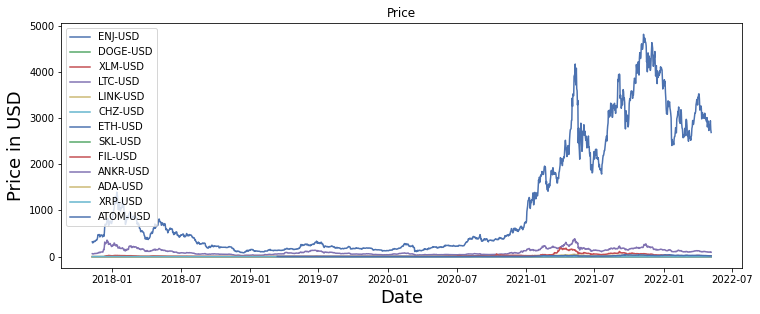

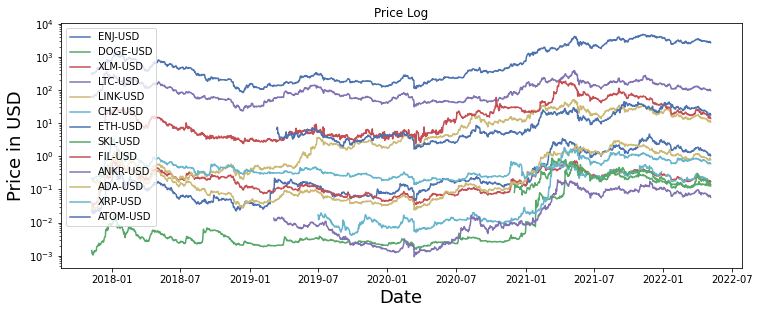

In [6]:
plt.figure(figsize=(12.2,4.5)) 
for i in df.columns.values:
    plt.plot( df[i],  label=i)
plt.title('Price')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price in USD',fontsize=18)
plt.legend(df.columns.values, loc='upper left')

plt.show()


plt.figure(figsize=(12.2,4.5)) 
for i in df.columns.values:
    plt.plot( df[i],  label=i)
plt.title('Price Log')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Price in USD',fontsize=18)
plt.legend(df.columns.values, loc='upper left')
plt.yscale('log')

plt.show()




In [ ]:
#Checking if any NaN values in the data
nullin_df = pd.DataFrame(df,columns=assets)
print(nullin_df.isnull().sum())


ENJ-USD        0
DOGE-USD       0
XLM-USD        0
LTC-USD        0
LINK-USD       0
CHZ-USD      629
ETH-USD        0
SKL-USD     1119
FIL-USD       34
ANKR-USD     482
ADA-USD        0
XRP-USD        0
ATOM-USD     490
dtype: int64


In [ ]:
#Annluaized Return
mu = expected_returns.mean_historical_return(df) 
#Sample Variance of Portfolio
Sigma = risk_models.sample_cov(df)

In [ ]:
#Max Sharpe Ratio - Tangent to the EF
ef = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('ENJ-USD', 0.1004), ('DOGE-USD', 0.19289), ('XLM-USD', 0.0), ('LTC-USD', 0.0), ('LINK-USD', 0.40206), ('CHZ-USD', 0.20289), ('ETH-USD', 0.0), ('SKL-USD', 0.0), ('FIL-USD', 0.0), ('ANKR-USD', 0.0), ('ADA-USD', 0.10176), ('XRP-USD', 0.0), ('ATOM-USD', 0.0)])


In [ ]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)
# 2year risk free rate - Treasury Yield 

Expected annual return: 83.1%
Annual volatility: 95.9%
Sharpe Ratio: 0.85


/usr/local/lib/python3.7/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  UserWarning,


(0.8312688628260074, 0.9585055971999246, 0.8463892805591968)

In [ ]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('ENJ-USD', 0.0), ('DOGE-USD', 0.0219), ('XLM-USD', 0.05174), ('LTC-USD', 0.08464), ('LINK-USD', 0.0), ('CHZ-USD', 0.05914), ('ETH-USD', 0.46381), ('SKL-USD', 0.0), ('FIL-USD', 0.07485), ('ANKR-USD', 0.10129), ('ADA-USD', 0.0), ('XRP-USD', 0.06905), ('ATOM-USD', 0.0736)])


In [ ]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 34.6%
Annual volatility: 75.2%
Sharpe Ratio: 0.10


(0.3456011138522676, 0.7515097955029479, 0.10059897329970469)

In [ ]:
from pypfopt.cla import CLA
from pypfopt import discrete_allocation

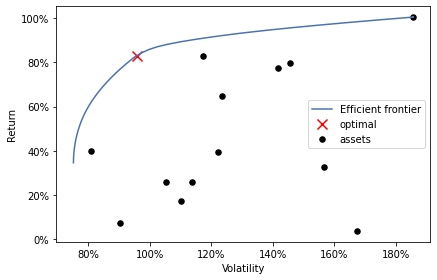

In [ ]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [ ]:
latest_prices = discrete_allocation.get_latest_prices(df)
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices, total_portfolio_value=10000).lp_portfolio() 
print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))


{'DOGE-USD': 142, 'XLM-USD': 2574, 'LTC-USD': 8, 'CHZ-USD': 101, 'ETH-USD': 2, 'FIL-USD': 48, 'ANKR-USD': 16308, 'XRP-USD': 1121, 'ATOM-USD': 35}
Leftover Fund value in$ after building minimum volatility portfolio is $-0.00


In [ ]:
#Max Sharpe Ratio Portfolio Allocation $10000
latest_prices1 = discrete_allocation.get_latest_prices(df)
allocation_shp, rem_shp = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices1, total_portfolio_value=10000).lp_portfolio() 
print(allocation_shp)
print("Leftover Fund value in$ after building Max Sharpe ratio portfolio is ${:.2f}".format(rem_shp))



{'ENJ-USD': 912, 'DOGE-USD': 14834, 'LINK-USD': 353, 'CHZ-USD': 11144, 'ADA-USD': 1237}
Leftover Fund value in$ after building Max Sharpe ratio portfolio is $0.03
